In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold

from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Чтение данных
raw = pd.read_csv('/kaggle/input/sbermarket-internship-competition/train.csv')
sub = pd.read_csv('/kaggle/input/sbermarket-internship-competition/sample_submission.csv')

Приведем данные в удобный для обучения вид

In [3]:
def preprocess_data(raw, sub):
    """
    Предобработка данных для задачи предсказания категории покупок.

    Параметры:
    raw (DataFrame): исходные данные с информацией о покупках.
    sub (DataFrame): данные файла отправки с идентификаторами пользователей и категорий.

    Возвращает:
    tuple: предобработанные данные для обучения и тестирования (train, test).
    """
    # разреженная матрица для временного использования
    train_raw = pd.get_dummies(raw, columns=['cart'], prefix='', prefix_sep='', dtype='bool')
    train_raw = train_raw.groupby(['user_id', 'order_completed_at']).any().reset_index()

    # счётчик заказов для каждого пользователя
    train_raw['order_number'] = train_raw.groupby(['user_id']).cumcount()
    train_raw = train_raw.drop('order_completed_at', axis=1)

    # разделение наборов данных по последней покупке
    last_order = train_raw.groupby(['user_id'])['order_number'].transform(max) == train_raw['order_number']
    train = train_raw[~last_order].groupby('user_id').sum().reset_index()
    valid = train_raw[last_order].reset_index(drop=True)

    # счётчик покупок для каждой категории для каждого пользователя
    train_melt = pd.melt(train, id_vars=['user_id'], var_name='category', value_name='ordered')
    valid_melt = pd.melt(valid, id_vars=['user_id'], var_name='category', value_name='target')

    train = train_melt.copy()

    # общее количество покупок для каждого пользователя
    order_number = valid[['user_id', 'order_number']].set_index('user_id').squeeze()
    train['orders_total'] = train['user_id'].map(order_number)

    # среднее количество каждой категории в покупках пользователя
    train['rating'] = train['ordered'] / train['orders_total']

    # user_id / category как в файле отправки
    train['id'] = train['user_id'].astype(str) + ';' + train['category']

    # целевая переменная (последняя известная покупка)
    train['target'] = valid_melt['target'].astype(int)

    # удаление пользователей/категорий, не представленных в файле отправки
    train = train[train.id.isin(sub.id.unique())].reset_index(drop=True)

    # проверка
    assert (train.sort_values('id')['id'].values == train.sort_values('id')['id'].values).all(), "Ошибка в идентификаторах"

    # счётчик покупок по всем пользователям (для представленных пользователей)
    total_ordered = train.groupby('category')['ordered'].sum()
    train['total_ordered'] = train['category'].map(total_ordered)

    # создание тестового набора
    test = train.copy()

    # увеличение счётчика заказов
    test['orders_total'] += 1

    # добавление последней покупки
    test['ordered'] = test['ordered'] + test['target']

    # пересчёт с учетом последнего заказа
    test_total_ordered = test.groupby('category')['ordered'].sum()
    test['total_ordered'] = test['category'].map(test_total_ordered)

    # пересчёт рейтинга с учетом последнего заказа
    test['rating'] = test['ordered'] / test['orders_total']

    # удаление целевой переменной из тестового набора
    test = test.drop('target', axis=1)

    return train, test

train, test = preprocess_data(raw, sub)

Посмотрим наши данные

### 1. **user_id**  
- **Описание**: Уникальный идентификатор пользователя.

### 2. **category**  
- **Описание**: Категория товара.

### 3. **ordered**  
- **Описание**: Общее количество покупок пользователя в данной категории.  
Показывает, насколько активно пользователь покупал товары определённой категории в прошлом.

### 4. **orders_total**  
- **Описание**: Общее количество заказов, сделанных пользователем.

### 5. **rating**  
- **Описание**: Доля заказов данной категории от общего числа заказов пользователя.  
Рассчитывается как `ordered / orders_total`. Указывает на предпочтения пользователя в отношении данной категории товаров.

### 6. **id**  
- **Описание**: Уникальный идентификатор для каждой пары пользователь-категория в формате `user_id;category`.

### 7. **target**  
- **Описание**: Бинарная целевая переменная, показывающая, была ли последняя покупка пользователя связана с данной категорией (`1` - была, `0` - не была).

### 8. **total_ordered**  
- **Описание**: Общее количество покупок всех пользователей для данной категории.  
Показывает популярность категории среди всех пользователей.ной категории при следующем заказе.

In [4]:
train.head()

,user_id,category,ordered,orders_total,rating,id,target,total_ordered
0,7,0,0,10,0.000000,7;0,1,12922
1,8,0,1,7,0.142857,8;0,0,12922
2,9,0,1,45,0.022222,9;0,0,12922
3,12,0,1,20,0.050000,12;0,1,12922
4,13,0,3,16,0.187500,13;0,0,12922


In [5]:
test.head()

,user_id,category,ordered,orders_total,rating,id,total_ordered
0,7,0,1,11,0.090909,7;0,14190
1,8,0,1,8,0.125000,8;0,14190
2,9,0,1,46,0.021739,9;0,14190
3,12,0,2,21,0.095238,12;0,14190
4,13,0,3,17,0.176471,13;0,14190


График распределения классов

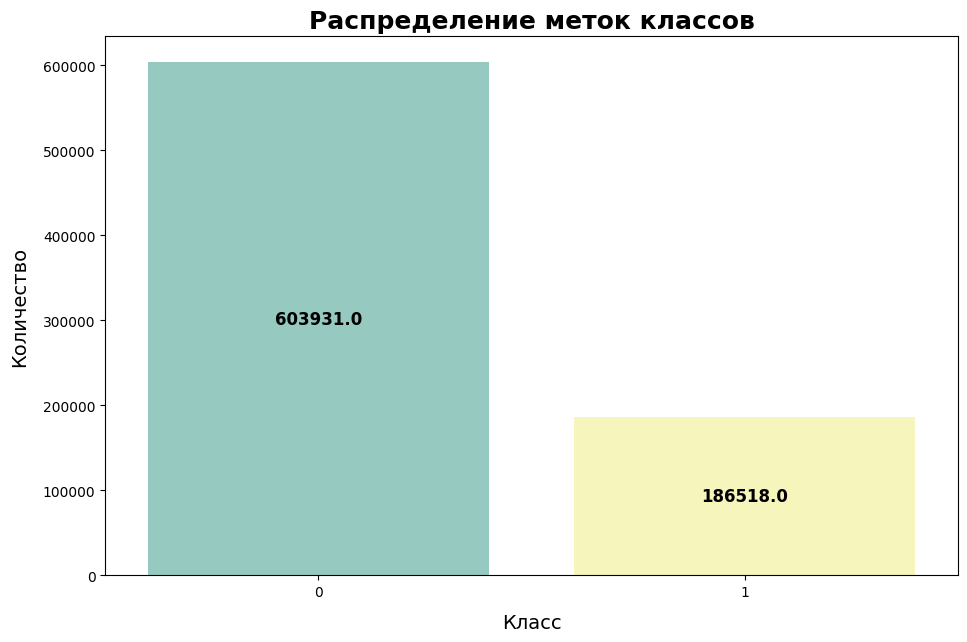

In [6]:
plt.figure(figsize=(11, 7))
ax = sns.countplot(data=train, x='target', palette="Set3")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center',
                fontsize=12, color='black', fontweight='bold') 
    
plt.title("Распределение меток классов", fontsize=18, fontweight='bold')
plt.xlabel("Класс", fontsize=14, labelpad=10)
plt.ylabel("Количество", fontsize=14, labelpad=10)

plt.show()

График распределения рейтингов

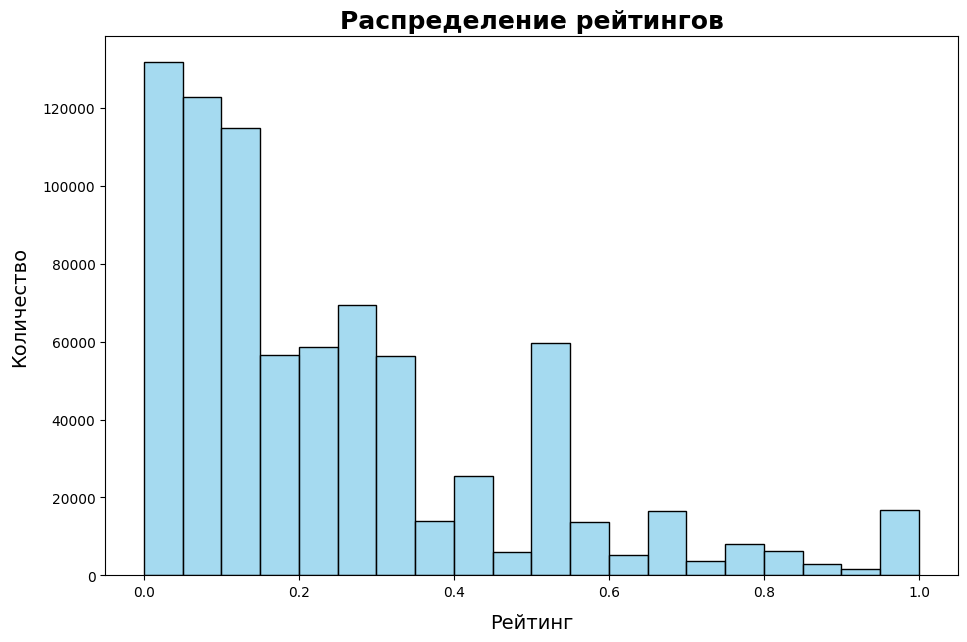

In [7]:
plt.figure(figsize=(11, 7))
ax = sns.histplot(data=train, x='rating', kde=False, bins=20, color="skyblue")
plt.title("Распределение рейтингов", fontsize=18, fontweight='bold')
plt.xlabel("Рейтинг", fontsize=14, labelpad=10)
plt.ylabel("Количество", fontsize=14, labelpad=10)
plt.show()

Корреляция phik (учитывает нелинейные зависимости)

interval columns not set, guessing: ['user_id', 'ordered', 'orders_total', 'rating', 'target', 'total_ordered']


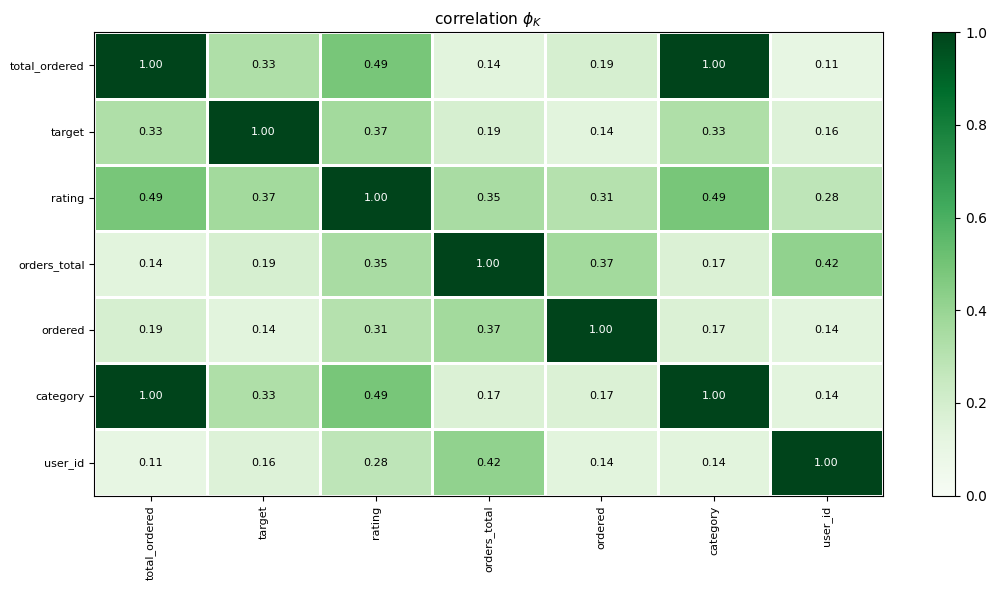

In [8]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = train.drop('id', axis=1).phik_matrix().round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

Обучение модели

In [9]:
# Для удобства определяем нужные столбцы
target = "target"
features = [
 'category',
 'ordered',
 'orders_total',
 'rating',
 'total_ordered',
 'user_id']
cat_features = ['category']

# Переводим категориальные признаки в int для catboost
train[cat_features] = train[cat_features].astype(int)
test[cat_features] = test[cat_features].astype(int)

В качестве модели использую бленд по 5 фолдам со стратификацией (без тюнинга гиперпараметров)

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool

def train_and_predict_catboost_cv(X, y, X_test, catboost_params=None, n_splits=5, cat_features=None):
    """
    Обучает модель CatBoost с кросс-валидацией и предсказывает вероятности на тестовом наборе.
    
    Параметры:
    - X (pd.DataFrame): Признаки полного набора данных.
    - y (pd.Series): Целевая переменная.
    - X_test (pd.DataFrame): Признаки тестового набора.
    - catboost_params (dict, optional): Параметры для модели CatBoost. Если не заданы, используется набор по умолчанию.
    - n_splits (int): Количество фолдов для StratifiedKFold. По умолчанию 5.
    - cat_features (list, optional): Список категориальных признаков.
    
    Возвращает:
    - np.array: Средние предсказанные вероятности положительного класса для тестового набора.
    - list: Список f1-score для каждого фолда.
    """
    # Задаем параметры CatBoost по умолчанию, если они не заданы
    if catboost_params is None:
        catboost_params = {
            'iterations': 4000,
            'random_state': 42,
            'thread_count': -1,
            'eval_metric': 'F1',
            'verbose': 100,
            'task_type': 'GPU',
            'auto_class_weights': 'Balanced'
        }
    
    # Настраиваем кросс-валидацию
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    test_preds = []
    
    # Создаем пул для тестового набора
    X_test_pool = Pool(X_test, cat_features=cat_features)
    
    for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Разделяем данные на тренировочные и валидационные
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        # Создаем пулы данных
        X_train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
        X_valid_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)
        
        # Инициализируем и обучаем модель
        model = CatBoostClassifier(**catboost_params)
        model.fit(X_train_pool, eval_set=X_valid_pool, verbose=100, early_stopping_rounds=140)
        
        # Предсказание на валидационном наборе
        val_pred = model.predict(X_valid_pool)
        score = f1_score(y_val_fold, val_pred)
        scores.append(score)
        print(f'Fold {i + 1} f1_score: {score:.6f}')
        
        # Предсказание вероятностей для тестового набора
        test_pred = model.predict_proba(X_test_pool)[:, 1]
        test_preds.append(test_pred)
    
    # Среднее по всем предсказаниям на тестовом наборе
    mean_test_pred = np.mean(test_preds, axis=0)
    print(f'Cross-validated f1_score: {np.mean(scores):.6f} +/- {np.std(scores):.6f}')
    
    return mean_test_pred, scores

mean_test_pred, scores = train_and_predict_catboost_cv(X=train[features], y=train[target], X_test=test[features], cat_features=cat_features)

Learning rate set to 0.023184
0:	learn: 0.7385688	test: 0.7409797	best: 0.7409797 (0)	total: 108ms	remaining: 7m 13s
100:	learn: 0.7455696	test: 0.7467175	best: 0.7478350 (76)	total: 3.21s	remaining: 2m 3s
200:	learn: 0.7471587	test: 0.7482405	best: 0.7482405 (200)	total: 6.11s	remaining: 1m 55s
300:	learn: 0.7477360	test: 0.7486644	best: 0.7487128 (299)	total: 8.95s	remaining: 1m 50s
400:	learn: 0.7481019	test: 0.7488150	best: 0.7488651 (337)	total: 11.9s	remaining: 1m 46s
500:	learn: 0.7485043	test: 0.7491065	best: 0.7491751 (496)	total: 14.8s	remaining: 1m 43s
600:	learn: 0.7487535	test: 0.7492235	best: 0.7492235 (600)	total: 17.6s	remaining: 1m 39s
700:	learn: 0.7487938	test: 0.7494174	best: 0.7494357 (677)	total: 20.6s	remaining: 1m 36s
800:	learn: 0.7491184	test: 0.7493880	best: 0.7495858 (750)	total: 23.5s	remaining: 1m 33s
900:	learn: 0.7492831	test: 0.7492815	best: 0.7495904 (832)	total: 26.5s	remaining: 1m 31s
bestTest = 0.7495904129
bestIteration = 832
Shrink model to first 

Сравним распределение целевых меток тестовых данных и тренировочных по порогу 0.5

In [11]:
print('Train target mean:', "%.5f" % train.target.mean())
print('Test target mean:', "%.5f" % (mean_test_pred > 0.5).astype(int).mean())

Train target mean: 0.23596
Test target mean: 0.26020


С гипотезой, то что данные на тесте должны иметь похожее распределение, что и на трейне, подберем новый порог

In [12]:
th = 0.8
train_mean = train.target.mean()
test_mean = (mean_test_pred > th).astype(int).mean()

while test_mean < train_mean:
    th -= 0.005
    test_mean = (mean_test_pred > th).astype(int).mean()
    
print('Threshold:', "%.4f" % th)
print('Train mean:', "%.5f" % train_mean)
print('New Test mean:', "%.5f" % test_mean)

Threshold: 0.5150
Train mean: 0.23596
New Test mean: 0.23970


Сабмит

In [13]:
test['target'] = mean_test_pred
test['target'] = test['target'].apply(lambda x: 1 if x >= th else 0)

submit = pd.merge(sub['id'], test[['id', 'target']], on='id')
submit.to_csv('cb_cv_blend_f1_eval_sub.csv', index=False)

leaderbord score 0.49085

Необходимый скор был достигнут, но так же есть много идей для его улучения, некоторые из которых:
- Добавление временных индикаторов и других фичей
- Тюнинг параметров модели
- Использование других моделей бустинга (LightGBM, XGBoost) для смешивания с CatBoost
- Стекинг